In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
	_genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
og_rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
og_rep_site = 'AATTGTGAGCGGATAACAATT'

In [4]:
## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
og_promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, og_rnap_site)

#rep_emat = rnap_emat[(len(rnap_site) - len(original_rep_site)):(len(rnap_site))]

In [6]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
	O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], og_rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [7]:
def generate_promoter_sequence(l_promoter, rnap_start, rep_start, l_rnap, l_rep, rnap_emat, rep_emat):
	# Initialize the promoter seq with random bases
	bases = ['A', 'C', 'G', 'T']
	promoter_seqs = np.random.choice(bases, l_promoter)

	# Function to get the base with the lowest energy for a given position
	def get_lowest_energy_base(emat, pos):
		energies = emat[pos]
		return bases[np.argmin(energies)]

	# Function to calculate the lowest energy base when sites overlap
	def get_lowest_energy_base_overlap(rnap_emat, rep_emat, pos_rnap, pos_rep):
		energies = rnap_emat[pos_rnap] + rep_emat[pos_rep]
		return bases[np.argmin(energies)]

	# Generate the promoter seq
	for i in range(l_rnap):
		rnap_pos = rnap_start + i

		if rnap_pos < l_promoter:
			promoter_seqs[rnap_pos] = get_lowest_energy_base(rnap_emat, i)

	for i in range(l_rep):
		rep_pos = rep_start + i

		if rep_pos < l_promoter:
			if rep_pos >= rnap_start and rep_pos < rnap_start + l_rnap:
				overlap_index = rep_pos - rnap_start
				promoter_seqs[rep_pos] = get_lowest_energy_base_overlap(rnap_emat, rep_emat, overlap_index, i)
			else:
				promoter_seqs[rep_pos] = get_lowest_energy_base(rep_emat, i)

	rnap_sites = "".join(promoter_seqs[rnap_start:rnap_start + l_rnap])
	rep_sites = "".join(promoter_seqs[rep_start:rep_start + l_rep])

	return "".join(promoter_seqs), rnap_sites, rep_sites

def generate_all_promoter_sequences(l_promoter, rnap_start, rep_start_initial, l_rnap, l_rep, rnap_emat, rep_emat, step_size=5):
	res = []

	for rep_start in range(rep_start_initial, rnap_start - l_rep + 1, -step_size):
		promoter, rnap_site, rep_site = generate_promoter_sequence(l_promoter, rnap_start, rep_start, l_rnap, l_rep, rnap_emat, rep_emat)
		rep_end = rep_start + l_rep - 1
		res.append((rep_start, rep_end, promoter, rnap_site, rep_site))

	return res

In [8]:
# Provided inputs
l_promoter = 160
rnap_start = og_promoter.find(og_rnap_site)
rep_start_initial = og_promoter.find(og_rep_site)
l_rnap = len(og_rnap_site)
l_rep = len(og_rep_site) - 5
step_size = 3

# Run the function with the provided inputs
res = generate_all_promoter_sequences(l_promoter, rnap_start, rep_start_initial, l_rnap, l_rep, rnap_emat, rep_emat,
										step_size=step_size)

In [9]:
def plot_footprint(promoter, df, region_params,
				   nbins=2, up_scaling_factor=1,
				   x_lims=None, fig_width=10, fig_height=2.9,
				   max_signal=None,
				   outfile=None,
				   return_fp=False,
				   smoothed=True, windowsize=3,
				   noxticks=False,
				   overlap=None):
	
	mut_list = df['seq'].values
	mu_data = df['norm_ct_1']
	upper_bound = up_scaling_factor * np.mean(mu_data)

	footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
											   pseudocount=10**(-6),
											   smoothed=smoothed, windowsize=windowsize)
	exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter)
	
	fig, ax = plt.subplots(figsize=(fig_width, fig_height))

	if x_lims is not None:
		ax.set_xlim(x_lims[0], x_lims[1])
	else:
		ax.set_xlim(-115, 45)

	if max_signal is None:
		max_signal = max(footprint)
	
	ax.set_ylim(top=max_signal*1.15)
	for region in region_params:
		if len(region)==4:
			tregs.footprint.label_binding_site(ax, region[0], region[1], max_signal, region[2], region[3])
		else:
			tregs.footprint.label_binding_site(ax, region[0], region[1], max_signal, region[2], region[3],
						   lifted=region[4])

	if smoothed:
		cut = int((windowsize - 1) / 2)
		x = np.arange(-115 + cut, 45 - cut)
	else:
		x = np.arange(-115, 45)
	shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
	ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)

	ax.tick_params(axis='x', labelsize=14)
	ax.tick_params(axis='y', labelsize=14)
	ax.set_ylabel('Mutual information\n(bits)', fontsize=14)
	ax.set_xlabel('Position relative to TSS', fontsize=14)

	plt.text(0.025, 0.9, f'Overlap:\n{overlap} bp', transform=plt.gca().transAxes, fontsize=11,
		 	 verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

	plt.tight_layout()
	if outfile is not None:
		plt.savefig(outfile, dpi=300, bbox_inches='tight')
	plt.show()

	if return_fp:
		return footprint

In [10]:
def calculate_overlap(rnap_start, rnap_end, rep_start, rep_end):
	overlap_start = max(rnap_start, rep_start)
	overlap_end = min(rnap_end, rep_end)
	if overlap_start < overlap_end:
		overlap_length = overlap_end - overlap_start + 1
		return overlap_length
	return 0

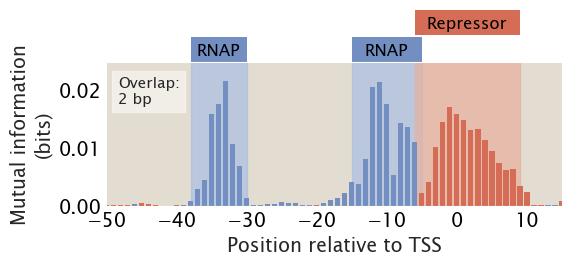

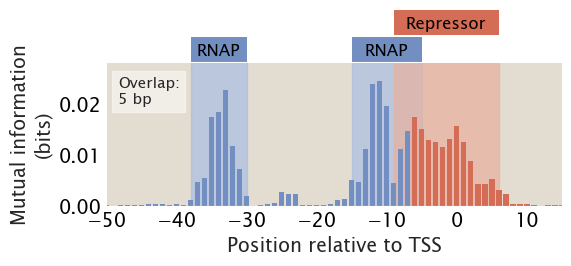

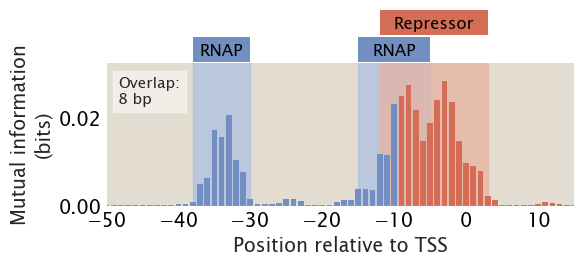

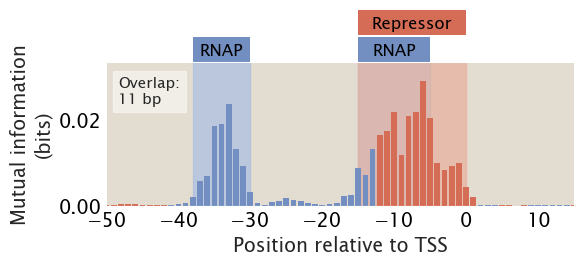

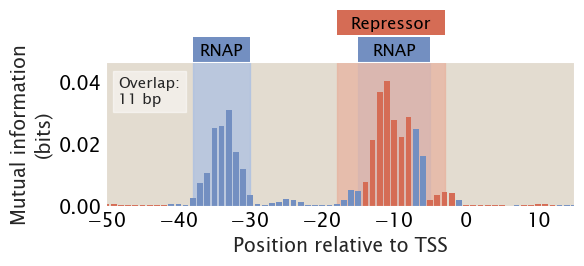

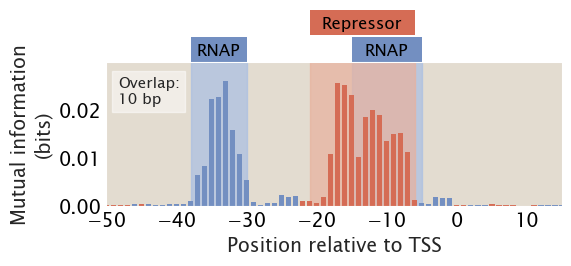

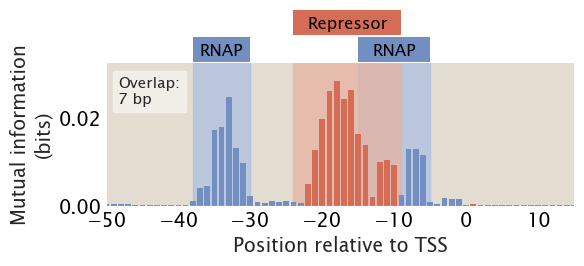

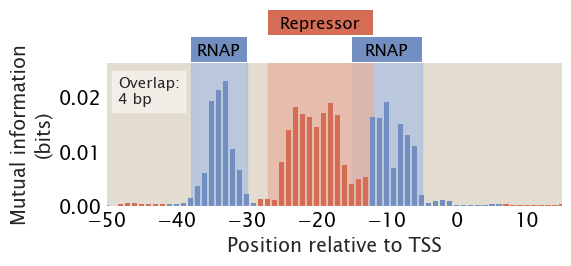

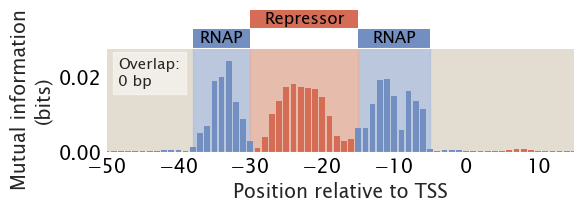

In [11]:
# Print the resulting promoter sequences
i = 0
for rep_start, rep_end, promoter, rnap_site, rep_site in res[2:11]:
	n_NS = len(genome)
	n_p = 5000
	n_r = 10
	ep_wt = -5
	er_wt = -15

	df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
							*[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

	overlap = True #False if i == 0 else True #or i == len(res) - 2
	l_overlap = calculate_overlap(-15 + 115, -5 + 115, rep_start, rep_end)
	noxticks = False if i == len(res[2:11]) - 1 else True
	fig_height = 3.2 if noxticks else 2.65

	region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'),
					(rep_start - 115, rep_end - 115, 'R', 'Repressor', overlap)]
	
	plot_footprint(promoter, df, region_params,
					x_lims=(-50, 15), fig_width=6,
					fig_height=fig_height, noxticks=noxticks, overlap=l_overlap,
					outfile='../plots/fig14/overlapping_fp{}.pdf'.format(i))
	i += 1